In [1]:
# from functools import partial
from pathlib import Path
# from typing import Optional, Tuple
# import cv2
# import fire
import numpy as np
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from PIL import Image
from scipy.sparse.linalg import eigsh
# from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
# from torchvision.utils import draw_bounding_boxes
from tqdm import tqdm
import extract_utils as utils
from torch.utils.data import Dataset, DataLoader
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimSiamPredictionHead, SimSiamProjectionHead
from torch import nn
import torchvision
from scipy.ndimage import affine_transform

## Extract Eigen Vectors

In [2]:
images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/images"
features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features"
output_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA32pred_ds_10"
filename='0125_resized'
which_matrix= 'laplacian'
which_color_matrix= 'knn'
which_features= 'k'
normalize=True
threshold_at_zero=True
lapnorm= True
K= 5
image_downsample_factor = None
image_color_lambda = 0.0
multiprocessing = 0
batch_size=2
epochs=10

## Incorporating SimSiam

In [3]:
# Define a custom dataset class
class Feature_Dataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __getitem__(self, index):
        return self.features[index]

    def __len__(self):
        return len(self.features)

In [4]:
class SimSiam(nn.Module):
    def __init__(self):
        super().__init__()
        self.projection_head = SimSiamProjectionHead(feats.shape[1], 128,feats.shape[1])
        self.prediction_head = SimSiamPredictionHead(feats.shape[1], 128, feats.shape[1])

    def forward(self, x):
        z = self.projection_head(x)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p

In [5]:
# def normalize_affinity_matrix(affinity_matrix, axis=0):
#     if axis == 1:
#         # Normalize by row-wise sums
#         row_sums = torch.sum(affinity_matrix, dim=1, keepdim=True)
#         print(row_sums)
#         normalized_matrix = affinity_matrix / row_sums
#     elif axis == 0:
#         # Normalize by column-wise sums
#         col_sums = torch.sum(affinity_matrix, dim=0, keepdim=True)
#         normalized_matrix = affinity_matrix / col_sums
#     else:
#         raise ValueError("Invalid axis. Axis must be either 0 or 1.")

#     return normalized_matrix

## Input Images

In [6]:
# pca_comp=32
# pca = PCA(n_components=pca_comp)
# utils.make_output_dir(output_dir)
# inputs = list(enumerate(sorted(Path(features_dir).iterdir())))
# for inp in tqdm(inputs[123:124]):
#     index, features_file = inp
#     print(index, features_file)
#      # Load
#     data_dict = torch.load(features_file, map_location='cpu')
#     print(data_dict.keys())   #['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape']
#     # print("shape=", data_dict['shape'], "k shape", data_dict['k'].shape, "patch_size=", data_dict['patch_size'])
#     image_id = data_dict['file'][:-4]
#     print(image_id)
#     # Load
#     output_file = str(Path(output_dir) / f'{image_id}.pth')
#     if Path(output_file).is_file():
#         print(f'Skipping existing file {str(output_file)}')
#         # break
#         # return  # skip because already generated
#
#     # Load affinity matrix
#     feats = data_dict[which_features].squeeze().cuda()
#     # print("Without normalizing, Features Shape is",feats.shape)
#     if normalize:
#         feats = F.normalize(feats, p=2, dim=-1)
#     # print("After normalization, Features Shape",feats.shape)
#     # print("which_matrix=", which_matrix)
#     # Eigenvectors of affinity matrix
#     if which_matrix == 'affinity_torch':
#         W = feats @ feats.T
#         # W_feat=contrastive_affinity(feats, feats.T)
#         # print("W shape=", W.shape)
#         if threshold_at_zero:
#             W = (W * (W > 0))
#             # print("W shape=", W.shape)
#         eigenvalues, eigenvectors = torch.eig(W, eigenvectors=True)
#         eigenvalues = eigenvalues.cpu()
#         eigenvectors = eigenvectors.cpu()
#         print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
#
#
#     # Eigenvectors of affinity matrix with scipy
#     elif which_matrix == 'affinity_svd':
#         USV = torch.linalg.svd(feats, full_matrices=False)
#         eigenvectors = USV[0][:, :K].T.to('cpu', non_blocking=True)
#         eigenvalues = USV[1][:K].to('cpu', non_blocking=True)
#         print("which matrix=",which_matrix,"eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
#
#     # Eigenvectors of affinity matrix with scipy
#     elif which_matrix == 'affinity':
#         # print("Without normalizing, Features Shape is",feats.shape)
#         W = (feats @ feats.T)
#         # W_feat=contrastive_affinity(feats, feats.T)
#         # print("W shape=", W.shape)
#         if threshold_at_zero:
#             W = (W * (W > 0))
#         W = W.cpu().numpy()
#         # print("W shape=", W.shape)
#         eigenvalues, eigenvectors = eigsh(W, which='LM', k=K)
#         eigenvectors = torch.flip(torch.from_numpy(eigenvectors), dims=(-1,)).T
#         print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
#
#     # Eigenvectors of matting laplacian matrix
#     elif which_matrix in ['matting_laplacian', 'laplacian']:
#
#         # Get sizes
#         B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
#         if image_downsample_factor is None:
#             image_downsample_factor = P
#         H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor
#
#         # Upscale features to match the resolution
#         if (H_patch, W_patch) != (H_pad_lr, W_pad_lr):
#             feats = F.interpolate(
#                 feats.T.reshape(1, -1, H_patch, W_patch),
#                 size=(H_pad_lr, W_pad_lr), mode='bilinear', align_corners=False
#             ).reshape(-1, H_pad_lr * W_pad_lr).T
#
#         ### Feature affinities
#         # print("Without normalizing, Features Shape is",feats.shape)
#
#         W_feat_ds = (feats @ feats.T)
#         layer=nn.Linear(pca_comp,pca_comp).cuda()
#         x0=feats
#         x0_arr=x0.cpu()
#         # print(x0_arr.shape)
#         z0_arr= pca.fit_transform(x0_arr)
#
#         # Define the affine transformation parameters
#         scale = np.random.uniform(0.8, 1.2)  # Random scaling factor between 0.8 and 1.2
#         translation = np.random.uniform(-10, 10, size=2)  # Random translation vector between -10 and 10 in both directions
#         rotation = np.random.uniform(-15, 15)  # Random rotation angle between -15 and 15 degrees
#         shear = np.random.uniform(-0.2, 0.2, size=2)  # Random shear factor between -0.2 and 0.2 in both directions
#
#         # Define the affine matrix
#         affine_matrix = np.array([[scale * np.cos(rotation), -shear[0] * scale * np.sin(rotation), translation[0]],
#                                   [shear[1] * scale * np.sin(rotation), scale * np.cos(rotation), translation[1]],
#                                   [0, 0, 1]])
#         z1_arr=affine_transform(z0_arr, affine_matrix)
# #         z1_arr=pca.fit_transform(z1_arr)
#         z0 = torch.from_numpy(z0_arr).float()
#         z1 = torch.from_numpy(z1_arr).float()
#
#         # feat_list.append(feats)
#         feat_dataset_z0 = Feature_Dataset(z0)
#         if feats.shape[0]%2==0:
#             features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True)
#         else:
#             features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True, drop_last=True)
#
#         feat_dataset_z1 = Feature_Dataset(z1)
#         if feats.shape[0]%2==0:
#             features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True)
#         else:
#             features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True, drop_last=True)
#         device = "cuda" if torch.cuda.is_available() else "cpu"
#
#         criterion = NegativeCosineSimilarity()
#         optimizer = torch.optim.SGD(layer.parameters(), lr=0.06)
#         print("Starting Training")
#         for epoch in range(epochs):
#             total_loss = 0
#             for z0_new,z1_new in zip(features_dataloader_z0,features_dataloader_z1):
#                 z0_new = z0_new.to(device)
#                 z1_new = z1_new.to(device)
#     #             print("z0_new.shape", z0_new.shape)
#     #             print("z1_new.shape", z1_new.shape)
#                 p0=layer(z0_new)
#                 p1=layer(z1_new)
#     #             print("p0.shape", p0.shape)
#     #             print("p1.shape", p1.shape)
#                 loss = 0.5 * (criterion(z0_new, p1) + criterion(z1_new, p0))
#                 total_loss += loss.detach()
#                 loss.backward()
#                 optimizer.step()
#                 optimizer.zero_grad()
#             avg_loss = total_loss / len(features_dataloader_z0)
#             print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
#         projected_feature=layer(z0.to(device))
#         print(projected_feature.shape)
#         W_feat_siam=torch.matmul(projected_feature, projected_feature.t())
#         W_feat_siam=torch.matmul(projected_feature[0], projected_feature[0].t())
#         W_feat=W_feat_ds + 0.1*W_feat_siam
# #         W_feat=normalize_affinity_matrix(W_feat_unnorm, axis=1)
#         # print("W_feat.shape=", W_feat.shape)
#         # print("W_feat.shape=", W_feat.shape)
#         # W_feat=contrastive_affinity(feats, feats.T)
#         if threshold_at_zero:
#             W_feat = (W_feat * (W_feat > 0))
#         W_feat = W_feat / W_feat.max()  # NOTE: If features are normalized, this naturally does nothing
#         # W_feat = W_feat.cpu().numpy()
#         W_feat = W_feat.detach().cpu().numpy()
#         # print("W_feat shape=",W_feat.shape)
#
#         ### Color affinities
#         # If we are fusing with color affinites, then load the image and compute
#         if image_color_lambda > 0:
#
#             # Load image
#             image_file = str(Path(images_root) / f'{image_id}.jpg')
#             image_lr = Image.open(image_file).resize((W_pad_lr, H_pad_lr), Image.BILINEAR)
#             image_lr = np.array(image_lr) / 255.
#
#             # Color affinities (of type scipy.sparse.csr_matrix)
#             if which_color_matrix == 'knn':
#                 W_lr = utils.knn_affinity(image_lr / 255)
#             elif which_color_matrix == 'rw':
#                 W_lr = utils.rw_affinity(image_lr / 255)
#
#             # Convert to dense numpy array
#             W_color = np.array(W_lr.todense().astype(np.float32))
#             # print("W_color shape", W_color.shape)
#
#         else:
#
#             # No color affinity
#             W_color = 0
#
#         # Combine
#         W_comb = W_feat + W_color * image_color_lambda  # combination
#         D_comb = np.array(utils.get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check
#         # print("W_comb shape= ", W_comb.shape, "D_comb shape",  D_comb.shape)
#         if lapnorm:
#             try:
#                 eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM', M=D_comb)
#             except:
#                 eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM', M=D_comb)
#         else:
#             try:
#                 eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM')
#             except:
#                 eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM')
#         eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()
#     print("eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
#     # Sign ambiguity
#     for k in range(eigenvectors.shape[0]):
#         if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
#             eigenvectors[k] = 0 - eigenvectors[k]
#
#     # Save dict
#     output_dict = {'eigenvalues': eigenvalues, 'eigenvectors': eigenvectors}
#     torch.save(output_dict, output_file)

In [7]:
# import matplotlib.pyplot as plt
# # numpy_array = W_feat.numpy()
#
# # Downsample the tensor by averaging values in small blocks
# downsampled_array = np.mean(W_feat.reshape(1024, 1, 1024, 1), axis=(1, 3))
# # downsampled_array = np.mean(W_feat.reshape(64, 16, 64, 16), axis=(1, 3))
#
# # Plot the heatmap of the downsampled tensor
# plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
# plt.colorbar()
# plt.title('PCA Projector + Linear Predictor')
# plt.savefig('/home/phdcs2/Downloads/' + 'PCA+LinearPredictor_1024' )
# plt.show()

In [8]:
# import matplotlib.pyplot as plt
# # numpy_array = W_feat.numpy()
#
# # Downsample the tensor by averaging values in small blocks
# downsampled_array = np.mean(W_feat.reshape(1024, 1, 1024, 1), axis=(1, 3))
# # downsampled_array = np.mean(W_feat.reshape(64, 16, 64, 16), axis=(1, 3))
#
# # Plot the heatmap of the downsampled tensor
# plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
# plt.colorbar()
# plt.title('PCA Projector + Linear Predictor')
# plt.savefig('/home/phdcs2/Downloads/' + 'PCA+LinearPredictor_1024' )
# plt.show()

## Config Masks

In [9]:
images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/srg_dot1PCA64pred_dssubmax_10/crf/laplacian_dino_vits16"
features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features_dot1PCA64pred_dssubmax_10/"
output_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA64pred_ds_10_plotfeature_new"

pca_comp=32
pca = PCA(n_components=pca_comp)
utils.make_output_dir(output_dir)
inputs = list(enumerate(sorted(Path(features_dir).iterdir())))
for inp in tqdm(inputs[123:124]):
    index, features_file = inp
    print(index, features_file)
     # Load
    data_dict = torch.load(features_file, map_location='cpu')
    print(data_dict.keys())   #['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape']
    # print("shape=", data_dict['shape'], "k shape", data_dict['k'].shape, "patch_size=", data_dict['patch_size'])
    image_id = data_dict['file'][:-4]
    print(image_id)
    # Load
    output_file = str(Path(output_dir) / f'{image_id}.pth')
    if Path(output_file).is_file():
        print(f'Skipping existing file {str(output_file)}')
        # break
        # return  # skip because already generated

    # Load affinity matrix
    feats = data_dict[which_features].squeeze().cuda()
    # print("Without normalizing, Features Shape is",feats.shape)
    if normalize:
        feats = F.normalize(feats, p=2, dim=-1)
    # print("After normalization, Features Shape",feats.shape)
    # print("which_matrix=", which_matrix)
    # Eigenvectors of affinity matrix
    if which_matrix == 'affinity_torch':
        W = feats @ feats.T
        # W_feat=contrastive_affinity(feats, feats.T)
        # print("W shape=", W.shape)
        if threshold_at_zero:
            W = (W * (W > 0))
            # print("W shape=", W.shape)
        eigenvalues, eigenvectors = torch.eig(W, eigenvectors=True)
        eigenvalues = eigenvalues.cpu()
        eigenvectors = eigenvectors.cpu()
        print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)


    # Eigenvectors of affinity matrix with scipy
    elif which_matrix == 'affinity_svd':
        USV = torch.linalg.svd(feats, full_matrices=False)
        eigenvectors = USV[0][:, :K].T.to('cpu', non_blocking=True)
        eigenvalues = USV[1][:K].to('cpu', non_blocking=True)
        print("which matrix=",which_matrix,"eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

    # Eigenvectors of affinity matrix with scipy
    elif which_matrix == 'affinity':
        # print("Without normalizing, Features Shape is",feats.shape)
        W = (feats @ feats.T)
        # W_feat=contrastive_affinity(feats, feats.T)
        # print("W shape=", W.shape)
        if threshold_at_zero:
            W = (W * (W > 0))
        W = W.cpu().numpy()
        # print("W shape=", W.shape)
        eigenvalues, eigenvectors = eigsh(W, which='LM', k=K)
        eigenvectors = torch.flip(torch.from_numpy(eigenvectors), dims=(-1,)).T
        print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

    # Eigenvectors of matting laplacian matrix
    elif which_matrix in ['matting_laplacian', 'laplacian']:

        # Get sizes
        B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
        if image_downsample_factor is None:
            image_downsample_factor = P
        H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor

        # Upscale features to match the resolution
        if (H_patch, W_patch) != (H_pad_lr, W_pad_lr):
            feats = F.interpolate(
                feats.T.reshape(1, -1, H_patch, W_patch),
                size=(H_pad_lr, W_pad_lr), mode='bilinear', align_corners=False
            ).reshape(-1, H_pad_lr * W_pad_lr).T

        ### Feature affinities
        # print("Without normalizing, Features Shape is",feats.shape)

        W_feat_ds = (feats @ feats.T)
        layer=nn.Linear(pca_comp,pca_comp).cuda()
        x0=feats
        x0_arr=x0.cpu()
        # print(x0_arr.shape)
        z0_arr= pca.fit_transform(x0_arr)

        # Define the affine transformation parameters
        scale = np.random.uniform(0.8, 1.2)  # Random scaling factor between 0.8 and 1.2
        translation = np.random.uniform(-10, 10, size=2)  # Random translation vector between -10 and 10 in both directions
        rotation = np.random.uniform(-15, 15)  # Random rotation angle between -15 and 15 degrees
        shear = np.random.uniform(-0.2, 0.2, size=2)  # Random shear factor between -0.2 and 0.2 in both directions

        # Define the affine matrix
        affine_matrix = np.array([[scale * np.cos(rotation), -shear[0] * scale * np.sin(rotation), translation[0]],
                                  [shear[1] * scale * np.sin(rotation), scale * np.cos(rotation), translation[1]],
                                  [0, 0, 1]])
        z1_arr=affine_transform(z0_arr, affine_matrix)
#         z1_arr=pca.fit_transform(z1_arr)
        z0 = torch.from_numpy(z0_arr).float()
        z1 = torch.from_numpy(z1_arr).float()

        # feat_list.append(feats)
        feat_dataset_z0 = Feature_Dataset(z0)
        if feats.shape[0]%2==0:
            features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True)
        else:
            features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True, drop_last=True)

        feat_dataset_z1 = Feature_Dataset(z1)
        if feats.shape[0]%2==0:
            features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True)
        else:
            features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True, drop_last=True)
        device = "cuda" if torch.cuda.is_available() else "cpu"

        criterion = NegativeCosineSimilarity()
        optimizer = torch.optim.SGD(layer.parameters(), lr=0.06)
        print("Starting Training")
        for epoch in range(epochs):
            total_loss = 0
            for z0_new,z1_new in zip(features_dataloader_z0,features_dataloader_z1):
                z0_new = z0_new.to(device)
                z1_new = z1_new.to(device)
    #             print("z0_new.shape", z0_new.shape)
    #             print("z1_new.shape", z1_new.shape)
                p0=layer(z0_new)
                p1=layer(z1_new)
    #             print("p0.shape", p0.shape)
    #             print("p1.shape", p1.shape)
                loss = 0.5 * (criterion(z0_new, p1) + criterion(z1_new, p0))
                total_loss += loss.detach()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            avg_loss = total_loss / len(features_dataloader_z0)
            print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
        projected_feature=layer(z0.to(device))
        print(projected_feature.shape)
        W_feat_siam=torch.matmul(projected_feature, projected_feature.t())
        W_feat_siam=torch.matmul(projected_feature[0], projected_feature[0].t())
        W_feat=W_feat_ds + 0.1*W_feat_siam
#         W_feat=normalize_affinity_matrix(W_feat_unnorm, axis=1)
        # print("W_feat.shape=", W_feat.shape)
        # print("W_feat.shape=", W_feat.shape)
        # W_feat=contrastive_affinity(feats, feats.T)
        if threshold_at_zero:
            W_feat = (W_feat * (W_feat > 0))
        W_feat = W_feat / W_feat.max()  # NOTE: If features are normalized, this naturally does nothing
        # W_feat = W_feat.cpu().numpy()
        W_feat = W_feat.detach().cpu().numpy()
        # print("W_feat shape=",W_feat.shape)

        ### Color affinities
        # If we are fusing with color affinites, then load the image and compute
        if image_color_lambda > 0:

            # Load image
            image_file = str(Path(images_root) / f'{image_id}.jpg')
            image_lr = Image.open(image_file).resize((W_pad_lr, H_pad_lr), Image.BILINEAR)
            image_lr = np.array(image_lr) / 255.

            # Color affinities (of type scipy.sparse.csr_matrix)
            if which_color_matrix == 'knn':
                W_lr = utils.knn_affinity(image_lr / 255)
            elif which_color_matrix == 'rw':
                W_lr = utils.rw_affinity(image_lr / 255)

            # Convert to dense numpy array
            W_color = np.array(W_lr.todense().astype(np.float32))
            # print("W_color shape", W_color.shape)

        else:

            # No color affinity
            W_color = 0

        # Combine
        W_comb = W_feat + W_color * image_color_lambda  # combination
        D_comb = np.array(utils.get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check
        # print("W_comb shape= ", W_comb.shape, "D_comb shape",  D_comb.shape)
        if lapnorm:
            try:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM', M=D_comb)
            except:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM', M=D_comb)
        else:
            try:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM')
            except:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM')
        eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()
    print("eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
    # Sign ambiguity
    for k in range(eigenvectors.shape[0]):
        if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
            eigenvectors[k] = 0 - eigenvectors[k]

    # Save dict
    output_dict = {'eigenvalues': eigenvalues, 'eigenvectors': eigenvectors}
    torch.save(output_dict, output_file)

  0%|          | 0/1 [00:00<?, ?it/s]

123 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features_dot1PCA64pred_dssubmax_10/0125_resized.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0125_resized
Starting Training
epoch: 00, loss: -0.12524
epoch: 01, loss: -0.13787
epoch: 02, loss: -0.13868
epoch: 03, loss: -0.13907
epoch: 04, loss: -0.13914
epoch: 05, loss: -0.13878
epoch: 06, loss: -0.13903
epoch: 07, loss: -0.14000
epoch: 08, loss: -0.14037
epoch: 09, loss: -0.13996
torch.Size([1024, 32])


100%|██████████| 1/1 [00:19<00:00, 19.02s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 1024])


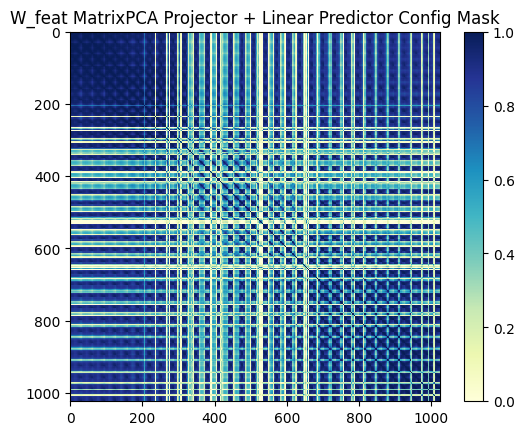

In [10]:
W_feat_configmask=W_feat
W_feat_ds_configmask=W_feat_ds
W_feat_ds_configmask
W_feat_siam_configmask=W_feat_siam
from matplotlib import pyplot as plt
type='PCA Projector + Linear Predictor Config Mask'
feat='W_feat Matrix'

# Downsample the tensor by averaging values in small blocks
downsampled_array = np.mean(W_feat_configmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_oursmask.reshape(32,32,32,32), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()

# feat='W_ds Matrix'
# # Downsample the tensor by averaging values in small blocks
#
# downsampled_array = np.mean(W_feat_ds_configmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# # downsampled_array = np.mean(W_feat_ds_oursmask.reshape(64, 16, 64, 16), axis=(1, 3))
#
# # Plot the heatmap of the downsampled tensor
# plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
# plt.colorbar()
# plt.title( feat + type)
# plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
# plt.show()

# import matplotlib.pyplot as plt
#
#
# feat='W_Siam Matrix'
# # Downsample the tensor by averaging values in small blocks
#
# downsampled_array = np.mean(W_feat_siam_configmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# # downsampled_array = np.mean(W_feat_siam_oursmask.reshape(64, 16, 64, 16), axis=(1, 3))
#
# # Plot the heatmap of the downsampled tensor
# plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
# plt.colorbar()
# plt.title( feat + type)
# plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
# plt.show()


## Ground Truth Masks

In [11]:
images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/ground_truth_mask"
features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/mask_features/"
output_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA32pred_ds_10_plotfeature_new"

pca_comp=32
pca = PCA(n_components=pca_comp)
utils.make_output_dir(output_dir)
W_feat=0
W_feat_ds=0
W_feat_siam=0
inputs = list(enumerate(sorted(Path(features_dir).iterdir())))
for inp in tqdm(inputs[123:124]):
    index, features_file = inp
    print(index, features_file)
     # Load
    data_dict = torch.load(features_file, map_location='cpu')
    print(data_dict.keys())   #['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape']
    # print("shape=", data_dict['shape'], "k shape", data_dict['k'].shape, "patch_size=", data_dict['patch_size'])
    image_id = data_dict['file'][:-4]
    print(image_id)
    # Load
    output_file = str(Path(output_dir) / f'{image_id}.pth')
    if Path(output_file).is_file():
        print(f'Skipping existing file {str(output_file)}')
        # break
        # return  # skip because already generated

    # Load affinity matrix
    feats = data_dict[which_features].squeeze().cuda()
    # print("Without normalizing, Features Shape is",feats.shape)
    if normalize:
        feats = F.normalize(feats, p=2, dim=-1)
    # print("After normalization, Features Shape",feats.shape)
    # print("which_matrix=", which_matrix)
    # Eigenvectors of affinity matrix
    if which_matrix == 'affinity_torch':
        W = feats @ feats.T
        # W_feat=contrastive_affinity(feats, feats.T)
        # print("W shape=", W.shape)
        if threshold_at_zero:
            W = (W * (W > 0))
            # print("W shape=", W.shape)
        eigenvalues, eigenvectors = torch.eig(W, eigenvectors=True)
        eigenvalues = eigenvalues.cpu()
        eigenvectors = eigenvectors.cpu()
        print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)


    # Eigenvectors of affinity matrix with scipy
    elif which_matrix == 'affinity_svd':
        USV = torch.linalg.svd(feats, full_matrices=False)
        eigenvectors = USV[0][:, :K].T.to('cpu', non_blocking=True)
        eigenvalues = USV[1][:K].to('cpu', non_blocking=True)
        print("which matrix=",which_matrix,"eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

    # Eigenvectors of affinity matrix with scipy
    elif which_matrix == 'affinity':
        # print("Without normalizing, Features Shape is",feats.shape)
        W = (feats @ feats.T)
        # W_feat=contrastive_affinity(feats, feats.T)
        # print("W shape=", W.shape)
        if threshold_at_zero:
            W = (W * (W > 0))
        W = W.cpu().numpy()
        # print("W shape=", W.shape)
        eigenvalues, eigenvectors = eigsh(W, which='LM', k=K)
        eigenvectors = torch.flip(torch.from_numpy(eigenvectors), dims=(-1,)).T
        print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

    # Eigenvectors of matting laplacian matrix
    elif which_matrix in ['matting_laplacian', 'laplacian']:

        # Get sizes
        B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
        if image_downsample_factor is None:
            image_downsample_factor = P
        H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor

        # Upscale features to match the resolution
        if (H_patch, W_patch) != (H_pad_lr, W_pad_lr):
            feats = F.interpolate(
                feats.T.reshape(1, -1, H_patch, W_patch),
                size=(H_pad_lr, W_pad_lr), mode='bilinear', align_corners=False
            ).reshape(-1, H_pad_lr * W_pad_lr).T

        ### Feature affinities
        # print("Without normalizing, Features Shape is",feats.shape)

        W_feat_ds = (feats @ feats.T)
        layer=nn.Linear(pca_comp,pca_comp).cuda()
        x0=feats
        x0_arr=x0.cpu()
        # print(x0_arr.shape)
        z0_arr= pca.fit_transform(x0_arr)

        # Define the affine transformation parameters
        scale = np.random.uniform(0.8, 1.2)  # Random scaling factor between 0.8 and 1.2
        translation = np.random.uniform(-10, 10, size=2)  # Random translation vector between -10 and 10 in both directions
        rotation = np.random.uniform(-15, 15)  # Random rotation angle between -15 and 15 degrees
        shear = np.random.uniform(-0.2, 0.2, size=2)  # Random shear factor between -0.2 and 0.2 in both directions

        # Define the affine matrix
        affine_matrix = np.array([[scale * np.cos(rotation), -shear[0] * scale * np.sin(rotation), translation[0]],
                                  [shear[1] * scale * np.sin(rotation), scale * np.cos(rotation), translation[1]],
                                  [0, 0, 1]])
        z1_arr=affine_transform(z0_arr, affine_matrix)
#         z1_arr=pca.fit_transform(z1_arr)
        z0 = torch.from_numpy(z0_arr).float()
        z1 = torch.from_numpy(z1_arr).float()

        # feat_list.append(feats)
        feat_dataset_z0 = Feature_Dataset(z0)
        if feats.shape[0]%2==0:
            features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True)
        else:
            features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True, drop_last=True)

        feat_dataset_z1 = Feature_Dataset(z1)
        if feats.shape[0]%2==0:
            features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True)
        else:
            features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True, drop_last=True)
        device = "cuda" if torch.cuda.is_available() else "cpu"

        criterion = NegativeCosineSimilarity()
        optimizer = torch.optim.SGD(layer.parameters(), lr=0.06)
        print("Starting Training")
        for epoch in range(epochs):
            total_loss = 0
            for z0_new,z1_new in zip(features_dataloader_z0,features_dataloader_z1):
                z0_new = z0_new.to(device)
                z1_new = z1_new.to(device)
    #             print("z0_new.shape", z0_new.shape)
    #             print("z1_new.shape", z1_new.shape)
                p0=layer(z0_new)
                p1=layer(z1_new)
    #             print("p0.shape", p0.shape)
    #             print("p1.shape", p1.shape)
                loss = 0.5 * (criterion(z0_new, p1) + criterion(z1_new, p0))
                total_loss += loss.detach()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            avg_loss = total_loss / len(features_dataloader_z0)
            print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
        projected_feature=layer(z0.to(device))
        print(projected_feature.shape)
        W_feat_siam=torch.matmul(projected_feature, projected_feature.t())
        W_feat_siam=torch.matmul(projected_feature[0], projected_feature[0].t())
        W_feat=W_feat_ds + 0.1*W_feat_siam
#         W_feat=normalize_affinity_matrix(W_feat_unnorm, axis=1)
        # print("W_feat.shape=", W_feat.shape)
        # print("W_feat.shape=", W_feat.shape)
        # W_feat=contrastive_affinity(feats, feats.T)
        if threshold_at_zero:
            W_feat = (W_feat * (W_feat > 0))
        W_feat = W_feat / W_feat.max()  # NOTE: If features are normalized, this naturally does nothing
        # W_feat = W_feat.cpu().numpy()
        W_feat = W_feat.detach().cpu().numpy()
        # print("W_feat shape=",W_feat.shape)

        ### Color affinities
        # If we are fusing with color affinites, then load the image and compute
        if image_color_lambda > 0:

            # Load image
            image_file = str(Path(images_root) / f'{image_id}.jpg')
            image_lr = Image.open(image_file).resize((W_pad_lr, H_pad_lr), Image.BILINEAR)
            image_lr = np.array(image_lr) / 255.

            # Color affinities (of type scipy.sparse.csr_matrix)
            if which_color_matrix == 'knn':
                W_lr = utils.knn_affinity(image_lr / 255)
            elif which_color_matrix == 'rw':
                W_lr = utils.rw_affinity(image_lr / 255)

            # Convert to dense numpy array
            W_color = np.array(W_lr.todense().astype(np.float32))
            # print("W_color shape", W_color.shape)

        else:

            # No color affinity
            W_color = 0

        # Combine
        W_comb = W_feat + W_color * image_color_lambda  # combination
        D_comb = np.array(utils.get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check
        # print("W_comb shape= ", W_comb.shape, "D_comb shape",  D_comb.shape)
        if lapnorm:
            try:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM', M=D_comb)
            except:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM', M=D_comb)
        else:
            try:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM')
            except:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM')
        eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()
    print("eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
    # Sign ambiguity
    for k in range(eigenvectors.shape[0]):
        if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
            eigenvectors[k] = 0 - eigenvectors[k]

    # Save dict
    output_dict = {'eigenvalues': eigenvalues, 'eigenvectors': eigenvectors}
    torch.save(output_dict, output_file)

Output dir: /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA32pred_ds_10_plotfeature_new


  0%|          | 0/1 [00:00<?, ?it/s]

123 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/mask_features/0125_resized.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0125_resized
Skipping existing file /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA32pred_ds_10_plotfeature_new/0125_resized.pth
Starting Training
epoch: 00, loss: -0.12653
epoch: 01, loss: -0.13489
epoch: 02, loss: -0.13627
epoch: 03, loss: -0.13661
epoch: 04, loss: -0.13649
epoch: 05, loss: -0.13696
epoch: 06, loss: -0.13718
epoch: 07, loss: -0.13747
epoch: 08, loss: -0.13772
epoch: 09, loss: -0.13716
torch.Size([1024, 32])


100%|██████████| 1/1 [00:19<00:00, 19.12s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 1024])


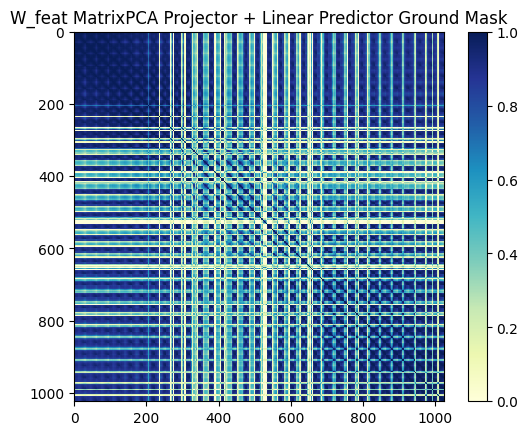

In [12]:
W_feat_groundmask=W_feat
W_feat_ds_groundmask=W_feat_ds
W_feat_siam_groundmask=W_feat_siam
type='PCA Projector + Linear Predictor Ground Mask'
feat='W_feat Matrix'

# Downsample the tensor by averaging values in small blocks
downsampled_array = np.mean(W_feat_configmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_oursmask.reshape(32,32,32,32), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()

# feat='W_ds Matrix'
# # Downsample the tensor by averaging values in small blocks
#
# downsampled_array = np.mean(W_feat_ds_configmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# # downsampled_array = np.mean(W_feat_ds_oursmask.reshape(64, 16, 64, 16), axis=(1, 3))
#
# # Plot the heatmap of the downsampled tensor
# plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
# plt.colorbar()
# plt.title( feat + type)
# plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
# plt.show()

# import matplotlib.pyplot as plt
#
#
# feat='W_Siam Matrix'
# # Downsample the tensor by averaging values in small blocks
#
# downsampled_array = np.mean(W_feat_siam_configmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# # downsampled_array = np.mean(W_feat_siam_oursmask.reshape(64, 16, 64, 16), axis=(1, 3))
#
# # Plot the heatmap of the downsampled tensor
# plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
# plt.colorbar()
# plt.title( feat + type)
# plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
# plt.show()


## Computing Frobenius Norm

In [13]:
# Calculate element-wise squared difference between the matrices
squared_diff = (W_feat_groundmask - W_feat_configmask) ** 2

# Sum the squared differences
sum_squared_diff = np.sum(squared_diff)

# Take the square root to get the Frobenius norm
frobenius_norm = np.sqrt(sum_squared_diff)

print("Frobenius Norm between ground and ours mask affinity:", frobenius_norm.item())

Frobenius Norm between ground and ours mask affinity: 168.187255859375
